In [1]:
import os
import time
import json
import argparse
from os.path import join, exists, splitext, basename
from imp import reload
from glob import glob
import shutil
from itertools import cycle
from imp import reload

import numpy as np

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt

from pixyz.models import Model
from pixyz.losses import ELBO, NLL

import models
from models import *
import utils 
from utils import * 

batch_size = 128
epochs = 10

plt.style.use("ggplot")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

log_dir = "./logs/mnist_gif"
if not exists(log_dir):
    os.makedirs(log_dir)

In [2]:
# data loader
seed = 4200

mnist_labeled_path  = "./data/labeled_mnist_image"
if exists(mnist_labeled_path):
    shutil.rmtree(mnist_labeled_path)
for i in range(10):
    os.makedirs(join(mnist_labeled_path, "{}".format(i)))

batch_size = 100

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)
unlabel_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset_test = datasets.MNIST('data/mnist', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

dataset = datasets.MNIST('data/mnist', train=True, download=True)

for i in range(seed, len(dataset)):
    for j in range(10):
        if (dataset[i][1]==j) and (len(glob(join(mnist_labeled_path, "{}/*".format(j)))) < 10):
            dataset[i][0].save(join(mnist_labeled_path, "{}/{}.png".format(j, i)))
    if len(glob(join(mnist_labeled_path, "*/*"))) == 100:
        break

        
labeled_dataset = datasets.ImageFolder(mnist_labeled_path, transform=transform)
label_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)

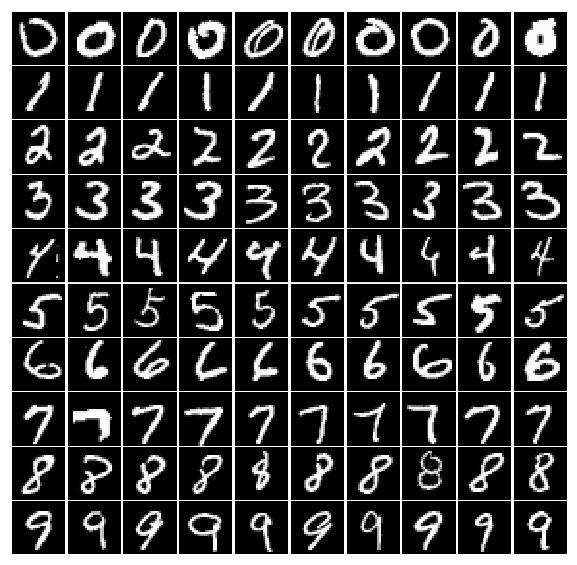

In [3]:
# ラベルつきデータの表示
samples, labels = iter(label_loader).next()
argsort = np.argsort(labels)
samples = samples[argsort]
samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1).squeeze()

# 横軸 z固定, y変化
# 縦軸 z変化, y固定
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(wspace=0., hspace=0.)
    plt.imshow(samples[i], cmap=plt.cm.gray)
plt.show()


In [4]:
z_dim = 63

# prior model p(z)
loc = torch.tensor(0.).to(device)
scale = torch.tensor(1.).to(device)
prior = Normal(loc=loc, scale=scale, var=["z"], dim=z_dim)

# initialize network
E = Encoder().to(device)
D = Decoder().to(device)
C = Classifier().to(device)
D_j = D * prior
D_j.to(device)

p(z) (Normal): Normal()
p(x|z,y) (Bernoulli): Decoder(
  (fc1): Sequential(
    (0): Linear(in_features=63, out_features=40, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=63, out_features=10, bias=True)
  )
  (fc_d): Sequential(
    (0): Linear(in_features=50, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
  )
  (conv_d): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)

In [5]:
# distributions for unsupervised learning
Eu = E.replace_var(x="x_u", y="y_u")
Du = D.replace_var(x="x_u", y="y_u")
Cu = C.replace_var(x="x_u", y="y_u")

ECu = Eu * Cu
Du_j = Du * prior

Du_j.to(device)
ECu.to(device)
Cu.to(device)


Classifier(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6272, out_features=256, bias=True)
    (1): Dropout(p=0.4)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): Dropout(p=0.4)
    (5): Softmax()
  )
)

In [6]:
elbo_u = ELBO(Du_j, ECu)
elbo = ELBO(D_j, E)
nll = NLL(C)

rate = 1 * (len(unlabel_loader) + len(label_loader)) / len(label_loader)

loss_cls = -elbo_u.mean() -elbo.mean() + (rate * nll).mean() 
print(loss_cls)

# 最適化
model = Model(loss_cls,test_loss=nll.mean(),
              distributions=[E, D, C], optimizer=optim.Adam, optimizer_params={"lr":5e-4})
print(model)


-(mean(E_p(z,y_u|x_u)[log p(x_u,z|y_u)/p(z,y_u|x_u)])) - mean(E_q(z|x,y)[log p(x,z|y)/q(z|x,y)]) + mean(log p(y|x) * 601.0)
Distributions (for training): 
  q(z|x,y), p(x|z,y), p(y|x) 
Loss function: 
  -(mean(E_p(z,y_u|x_u)[log p(x_u,z|y_u)/p(z,y_u|x_u)])) - mean(E_q(z|x,y)[log p(x,z|y)/q(z|x,y)]) + mean(log p(y|x) * 601.0) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.0005
      weight_decay: 0
  )


In [ ]:
train_hist = {}
train_hist["precision"] = []
for epoch in range(100):
    train_loss = 0
    for (x, y), (x_u, y_u) in tqdm(zip(cycle(label_loader), unlabel_loader), total=len(unlabel_loader)):
        x = x[:, 0:1].to(device)
        y = torch.eye(10)[y].to(device)
        x_u = x_u.to(device)        
        loss = model.train({"x": x, "y": y, "x_u": x_u})
        train_loss += loss
        
    train_loss = train_loss * unlabel_loader.batch_size / len(unlabel_loader.dataset)
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    train_hist["precision"].append(compute_precision(C, test_loader))
    plot_sample(D, epoch)
    plot_loss(train_hist)


In [ ]:
# pretrain

# initialize network
C = Classifier().to(device)

# optimizer
C_optimizer = optim.Adam(C.parameters(), lr=0.001, betas=(0.5, 0.999))

# loss
criterion_CE = nn.CrossEntropyLoss()

for epoch in tqdm(range(200)):
    for batch_idx, (x_, y_) in enumerate(label_loader):
        C.train()
        x_ = x_[:, 0:1].to(device)
        y_ = y_.to(device)
        y_vec_ = torch.eye(10)[y_].to(device)

        C_optimizer.zero_grad()

        C_pred_label = C.sample(x_, reparam=True)["y"]
        C_loss = criterion_CE(C_pred_label, y_)
        C_loss.backward()
        
        C_optimizer.step()
        
precision = compute_precision(C, test_loader)

In [ ]:
from pixyz.distributions import Normal, Bernoulli, RelaxedCategorical, Categorical

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
            
            
class Classifier(RelaxedCategorical):    
    def __init__(self, y_dim=10):
        super(Classifier, self).__init__(cond_var=["x"], var=["y"], temperature=0.1)
        self.input_height = 28
        self.input_width = 28

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, padding=2),   # 28x28 ⇒ 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, padding=2), # 14x14 ⇒ 7x7
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.fc =  nn.Sequential(
            nn.Linear((self.input_height // 4) * (self.input_width // 4) * 128, 256),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(256, y_dim),
            nn.Dropout(p=0.4),
            nn.Softmax(dim=1)            
        )
        initialize_weights(self)
        
    def forward(self, x):
        c1 = self.conv1(x)
        c2 = self.conv2(c1)
        c2_flat = c2.view(c2.size(0), -1)
        out = self.fc(c2_flat)
        return {"probs": out}

In [ ]:
lr = 0.0002

# initialize network
C = Classifier().to(device)

# optimizer
C_optimizer = optim.Adam(C.parameters(), lr=0.001, betas=(0.5, 0.999))

# loss
criterion_BCE = nn.BCELoss()
criterion_CE = nn.CrossEntropyLoss()

In [ ]:
train_hist = {}
train_hist['C_loss'] = []
for epoch in tqdm(range(400)):
    for batch_idx, (x_, y_) in enumerate(label_loader):
        C.train()
        x_ = x_[:, 0:1].to(device)
        y_ = y_.to(device)
        y_vec_ = torch.eye(10)[y_].to(device)

        # update C network
        C_optimizer.zero_grad()

        C_pred_label = C(x_)["probs"]
        #C_pred_label = C.sample(x_, reparam=True)["y"]
        
        C_loss_label = criterion_CE(C_pred_label, y_)
        #C_loss_label = criterion_BCE(C_pred_label, y_vec_)
        C_loss = C_loss_label
        #samples = C.sample(x_)
        #C_loss = - C.log_likelihood({"x": x_, "y": y_vec_}).mean()

        C_loss.backward()
        C_optimizer.step()
    
        train_hist['C_loss'].append(C_loss.item())
plt.plot(train_hist["C_loss"])
plt.show()

precision = compute_precision(C, test_loader)
print(precision)

In [ ]:
train_hist = {}
train_hist['C_loss'] = []
for epoch in tqdm(range(100)):
    for batch_idx, (x_, y_) in enumerate(label_loader):
        C.train()
        x_ = x_[:, 0:1].to(device)
        y_ = y_.to(device)
        y_vec_ = torch.eye(10)[y_].to(device)

        # update C network
        C_optimizer.zero_grad()

        #C_pred_label = C(x_)["probs"]
        #C_pred_label = C.sample(x_)["y"]
        #C_pred_label.requires_grad = True
        
        #C_loss_label = criterion_CE(C_pred_label, y_)
        #C_loss_label = criterion_BCE(C_pred_label, y_vec_)
        #C_loss = C_loss_label
        #samples = C.sample(x_)
        C_loss = - C.log_likelihood({"x": x_, "y": y_vec_}).mean()

        C_loss.backward()
        C_optimizer.step()
    
        train_hist['C_loss'].append(C_loss.item())
plt.plot(train_hist["C_loss"])
plt.show()

precision = compute_precision(C, test_loader)
print(precision)

In [ ]:
reload(models)
reload(utils)
from models import * 
from utils import *